# Chirp radio transmission simulation

To run this notebook you need numpy, scipy, matplotlib, cython, pandas and seaborn. 

In [1]:
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.figsize'] = (12, 9)

import pandas
import numpy
from scipy import stats

import pyximport
pyximport.install(reload_support=True)
from imp import reload
import chirptx

## Parameters 

In [2]:
# Everything here is in seconds

# Simulate 24 hours stepping by 0.01 seconds
SIMULATION_DURATION = 24 * 60 * 60
SIMULATION_TIME_STEP = 0.01

TRANSMISSION_DURATION = 0.04

# Transmission periods for behaviours
PERIOD_MEAN = 60
PERIOD_SPREAD = 1

# Device turn-on time is staggered. This is the mean.
MEAN_TURN_ON_DELAY = 2

## Behaviours

The main simulation is defined in the file `chirptx.pyx`. It's written in Cython for speed. The following two functions are wrappers. There are two behaviours.

The `periodic` behaviour transmits with a fixed period each time. Periods are different for each device, uniformly randomized at production time.

The `uniform_spread` behaviour randomizes the period between transmissions with a uniform distribution in the interval _[mean - spread/2; mean + spread/2)_.

The `poisson` behaviour randomizes the period between transmission with an exponential distribution with scale `PERIOD_MEAN`. The result is a Poisson process. 

In [3]:
reload(chirptx)

def periodic(nchirps):
    # periods ~ Uniform(mean - spread/2, mean + spread/2)
    periods = stats.uniform.rvs(loc=PERIOD_MEAN - PERIOD_SPREAD / 2,
                                scale=PERIOD_SPREAD,
                                size=nchirps)
    return [chirptx.Periodic(TRANSMISSION_DURATION, p) for p in periods]
    

def uniform_spread(nchirps):
    return [chirptx.UniformSpread(TRANSMISSION_DURATION, PERIOD_MEAN, PERIOD_SPREAD)
            for i in range(nchirps)]

def poisson(nchirps):
    return [chirptx.Poisson(TRANSMISSION_DURATION, PERIOD_MEAN)
            for i in range(nchirps)]

## Setup and execution

Simulations are run for each behaviour and exponentially increasing numbers of chirps. The main result of each simulation is a probability that a single transmission will fail, independent of everything else.

In [4]:
data = pandas.DataFrame(data=dict(
        nchirps=numpy.unique(numpy.ceil(numpy.power(2, numpy.arange(1, 8.01, step=0.2))).astype(numpy.int)),
))
data.index = data.nchirps
numpy.array(data.nchirps)

array([  2,   3,   4,   5,   6,   7,   8,  10,  11,  13,  14,  16,  19,
        22,  25,  28,  32,  37,  43,  49,  56,  64,  74,  85,  98, 112,
       128, 148, 169, 195, 223, 256])

In [5]:
# Seed RNG for reproducibility
numpy.random.seed(1)

# Pregenerate common startup delays.
# ~ Exponential, with mean and sd = 2
delays = [numpy.random.exponential(MEAN_TURN_ON_DELAY, size=n) for n in data.nchirps]

def run_sim(gen_actors):
    name = gen_actors.__name__
    pfail_col = 'pfail_{}'.format(name)
    txcount_col = 'txcount_{}'.format(name)
    data[pfail_col] = float(0)
    data[txcount_col] = 0
    for i, nchirps in enumerate(data.nchirps):
        s = chirptx.simulate(
            SIMULATION_DURATION,
            SIMULATION_TIME_STEP,
            numpy.array(gen_actors(nchirps)),
            delays[i],
        )
        p = s.failures / s.transmissions
        data[pfail_col].at[nchirps] = p
        data[txcount_col].at[nchirps] = s.transmissions
        print("nchirps={nchirps}\tntx={s.transmissions}\tP(tx fail|{name})={p:.4f}".format(**locals()))

run_sim(periodic)
run_sim(uniform_spread)
run_sim(poisson)

# Save results to disk
data.to_pickle('data.pickle')

nchirps=2	ntx=2862	P(tx fail|periodic)=0.0007
nchirps=3	ntx=4303	P(tx fail|periodic)=0.0000
nchirps=4	ntx=5766	P(tx fail|periodic)=0.0031
nchirps=5	ntx=7222	P(tx fail|periodic)=0.0044
nchirps=6	ntx=8650	P(tx fail|periodic)=0.0060
nchirps=7	ntx=10070	P(tx fail|periodic)=0.0083
nchirps=8	ntx=11513	P(tx fail|periodic)=0.0090
nchirps=10	ntx=14372	P(tx fail|periodic)=0.0107
nchirps=11	ntx=15860	P(tx fail|periodic)=0.0125
nchirps=13	ntx=18695	P(tx fail|periodic)=0.0164
nchirps=14	ntx=20141	P(tx fail|periodic)=0.0179
nchirps=16	ntx=23065	P(tx fail|periodic)=0.0186
nchirps=19	ntx=27419	P(tx fail|periodic)=0.0229
nchirps=22	ntx=31680	P(tx fail|periodic)=0.0256
nchirps=25	ntx=35956	P(tx fail|periodic)=0.0296
nchirps=28	ntx=40315	P(tx fail|periodic)=0.0330
nchirps=32	ntx=46109	P(tx fail|periodic)=0.0388
nchirps=37	ntx=53265	P(tx fail|periodic)=0.0452
nchirps=43	ntx=61923	P(tx fail|periodic)=0.0698
nchirps=49	ntx=70442	P(tx fail|periodic)=0.0612
nchirps=56	ntx=80596	P(tx fail|periodic)=0.0675
nchi

## Results

Note that the plot is log-log scale.

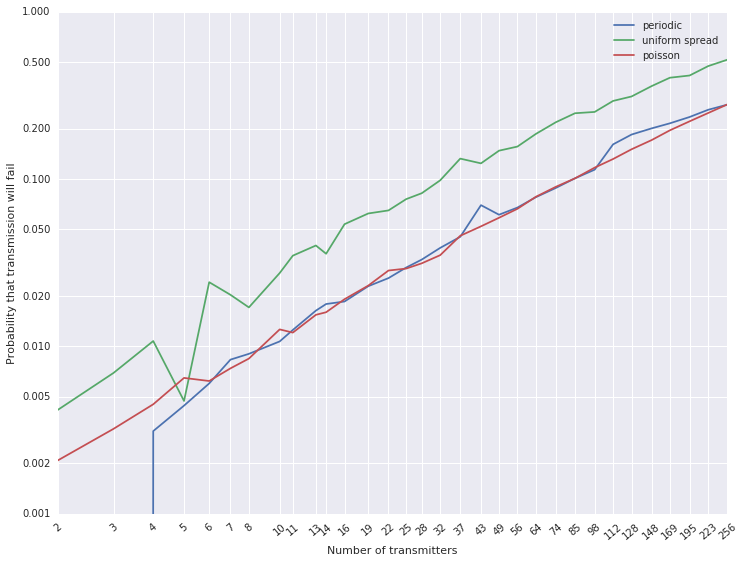

In [9]:
fig, ax = plt.subplots()
data.pfail_periodic.plot(label="periodic", loglog=True)
data.pfail_uniform_spread.plot(label="uniform spread", loglog=True)
data.pfail_poisson.plot(label="poisson", loglog=True)
plt.legend()
plt.xticks(data.nchirps, rotation=40)
plt.yticks([0.001, 0.002, 0.005, 0.010, 0.020, 0.050, 0.100, 0.200, 0.500, 1.000])
plt.ylim(0.001, 1)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel("Number of transmitters")
plt.ylabel("Probability that transmission will fail")

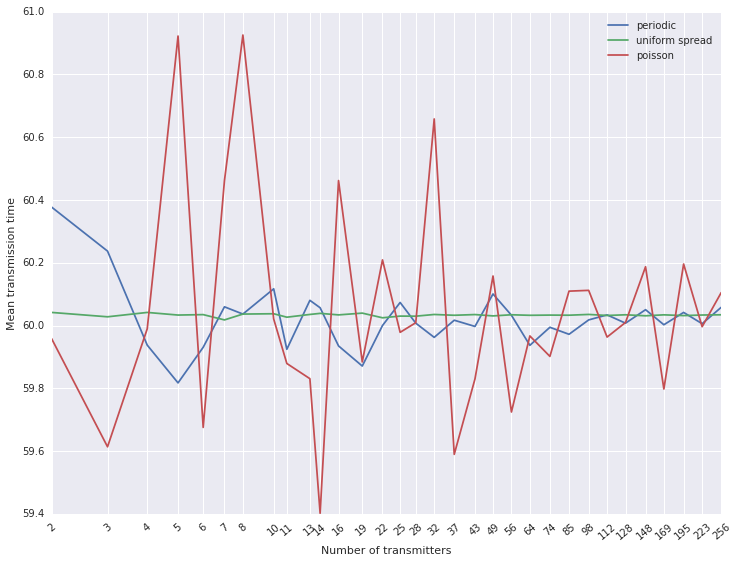

In [10]:
fig, ax = plt.subplots()
(SIMULATION_DURATION / data.txcount_periodic * data.nchirps).plot(label="periodic", logx=True)
(SIMULATION_DURATION / data.txcount_uniform_spread * data.nchirps).plot(label="uniform spread", logx=True)
(SIMULATION_DURATION / data.txcount_poisson * data.nchirps).plot(label="poisson", logx=True)
plt.legend()
plt.xticks(data.nchirps, rotation=40)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.xlabel("Number of transmitters")
plt.ylabel("Mean transmission time")

## Conclusion

The `uniform_spread` behaviour performs consistently worse on failure probability.

`periodic` and `poisson` fail at about the same rate, but `poisson` has a larger transmission time variance (=mean period squared). This could be considered a disadvantage (it's less predictable therefore harder to debug), but it doesn't require programming the devices differently (like `periodic` does).